In [167]:
print("testing")

testing


In [168]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",
    temperature=0
)
response=llm.invoke("what is length of wall of china?")

In [169]:
import requests
from dotenv import load_dotenv
import os

# Load .env file
load_dotenv()

# Retrieve API Key
api_key = os.getenv("WEATHER_API_KEY")

def get_weather(city):
    if not api_key:
        return {"error": "API Key not found!"}
    
    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"
    
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        return {"error": f"Failed to fetch data. Status Code: {response.status_code}"}

# Test Request
# city = "Mumbai"
# weather_info = get_weather(city)
# print(weather_info['weather'])

In [170]:
import requests

# Function to get hotels, attractions, and activities separately
def get_places(city):
    query_hotels = f"""
    [out:json];
    area[name="{city}"]->.searchArea;
    node["tourism"="hotel"](area.searchArea);
    out;
    """
    
    query_attractions = f"""
    [out:json];
    area[name="{city}"]->.searchArea;
    node["tourism"="attraction"](area.searchArea);
    out;
    """
    
    query_activities = f"""
    [out:json];
    area[name="{city}"]->.searchArea;
    (
        node["leisure"](area.searchArea);
        node["sport"](area.searchArea);
    );
    out;
    """
    
    url = "https://overpass-api.de/api/interpreter"
    
    response_hotels = requests.get(url, params={"data": query_hotels})
    response_attractions = requests.get(url, params={"data": query_attractions})
    response_activities = requests.get(url, params={"data": query_activities})
    
    def extract_places(response):
        if response.status_code == 200:
            data = response.json()
            return [node["tags"].get("name:en", node["tags"].get("name", "Unnamed Place")) for node in data["elements"]]
        return ["Failed to fetch places"]

    hotels = extract_places(response_hotels)
    attractions = extract_places(response_attractions)
    activities = extract_places(response_activities)
    
    return {"hotels": hotels[:5], "attractions": attractions[:5], "activities": activities[:5]}

# Example Usage
# city = "Mumbai"
# places = get_places(city)
# print(places)

In [171]:
import requests
from typing import Dict, Any

def get_hotel_prices(search_params: Dict[str, Any]) -> str:
    """Fetch hotel prices using Xotelo API with dictionary input."""
    api_key = "your-xotelo-api-key"  # Replace with your Xotelo API key
    print("Input parameters:", search_params)

    # Extract parameters from dictionary with defaults
    hotel_key = search_params.get("hotel_key", "")  # Default to provided hotel_key
    check_in = search_params.get("check_in", "")
    check_out = search_params.get("check_out", "")
    city = search_params.get("city", "")  # Optional, for logging or filtering

    # Construct the Xotelo API URL
    url = f"https://data.xotelo.com/api/rates?hotel_key={hotel_key}&chk_in={check_in}&chk_out={check_out}"
    # headers = {"Authorization": f"Bearer {api_key}"}

    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        # Adjust parsing based on Xotelo /rates endpoint response
        rates = data.get("result", {}).get("rates", [])
        if not rates:
            return "No rates found for the specified hotel and dates."
        return str([{
            "vendor": rate.get("name"),
            "price": rate.get("rate"),
              # Adjust based on actual response
        } for rate in rates[:3]])  # Top 3 rates
    except requests.RequestException as e:
        return f"Error fetching hotel prices: {str(e)}"

# Example dictionary


# Call the function



In [172]:
from langchain.tools import tool
@tool
def whehter(query: str) -> list:
    """
    whehter response.

    Args:
        query (string): string consist of city name.
        

    Returns:
        list: return response from get_weather function.
    """
    
    weather_info = get_weather(query)
    return weather_info

@tool
def places(query:str)->dict:
    """
    places response.

    Args:
        query (string): string consist of city name.
        

    Returns:
        dtct: return dict from get_places function.
    """
    places = get_places(query)
    return places


@tool
def prices(query: dict) -> dict:
    """
    prices response.

    Args:
        query (string): string consist of city name.
        

    Returns:
        dtct: return dict from get_prices function.
    """
    prices = get_hotel_prices(query)
    return prices





In [173]:
tools=[whehter, places,prices]
llm_with_tools=llm.bind_tools(tools)

In [174]:
response=llm_with_tools.invoke("suggest some hotel in chennai")

In [175]:
response.tool_calls

[{'name': 'places',
  'args': {'query': 'Chennai'},
  'id': 'v25z7rns2',
  'type': 'tool_call'}]

In [176]:
SYSTEM_PROMPT="You are a helpful assistant tasked with providing a weather information and tourist attraction and hotel information."
user_query=[]


In [177]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START

def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

In [178]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
builder=StateGraph(MessagesState)
builder.add_node("llm_decision_step",function_1)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"llm_decision_step")
builder.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)
builder.add_edge("tools","llm_decision_step")

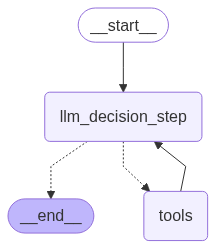

In [179]:
from IPython.display import Image, display
trip_advisor=builder.compile()

display(Image(trip_advisor.get_graph().draw_mermaid_png()))

In [180]:
message=[HumanMessage(content="Please suggest weather in GOA and tourist attraction places and provide hotel prices in INR and checkin dates are 2025-12-01 and checkout data 2025-12-02 ?")]

In [181]:
response=trip_advisor.invoke({"messages":message})

In [182]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Please suggest weather in GOA and tourist attraction places and provide hotel prices in INR and checkin dates are 2025-12-01 and checkout data 2025-12-02 ?
================================== Ai Message ==================================
Tool Calls:
  whehter (8se8vcvkr)
 Call ID: 8se8vcvkr
  Args:
    query: GOA
================================= Tool Message =================================
Name: whehter

{"coord": {"lon": 74.0833, "lat": 15.3333}, "weather": [{"id": 802, "main": "Clouds", "description": "scattered clouds", "icon": "03n"}], "base": "stations", "main": {"temp": 25, "feels_like": 25.85, "temp_min": 25, "temp_max": 25, "pressure": 1009, "humidity": 88, "sea_level": 1009, "grnd_level": 997}, "visibility": 10000, "wind": {"speed": 4.38, "deg": 242, "gust": 10.37}, "clouds": {"all": 33}, "dt": 1750179095, "sys": {"country": "IN", "sunrise": 1750120414, "sunset": 1750167336}, "timezone": 19800,

In [183]:
trip_advisor.invoke({"messages":message})

{'messages': [HumanMessage(content='Please suggest weather in GOA and tourist attraction places and provide hotel prices in INR and checkin dates are 2025-12-01 and checkout data 2025-12-02 ?', additional_kwargs={}, response_metadata={}, id='23577734-8c47-4481-8f44-ca6cfb39fd66'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'pfvt3kxxv', 'function': {'arguments': '{"query":"GOA"}', 'name': 'whehter'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 312, 'prompt_tokens': 341, 'total_tokens': 653, 'completion_time': 1.142584578, 'prompt_time': 0.023153479, 'queue_time': 0.05287598099999999, 'total_time': 1.165738057}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--bfa98a8e-51a1-4851-b3f8-f4ad3a656571-0', tool_calls=[{'name': 'whehter', 'args': {'query': 'GOA'}, 'id': 'pfvt3kxxv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 341, 'o